In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-11-10 10:10:56.204946: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 10:10:57.599096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 10:11:02.394319: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print("--- Initial Data Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 256s 2us/step
--- Initial Data Shapes ---
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
# Normalize pixel values
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Convert class labels into one-hot encoded format
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

print("\n--- Preprocessed Data Shapes ---")
print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")


--- Preprocessed Data Shapes ---
X_train_norm shape: (50000, 32, 32, 3)
y_train_one_hot shape: (50000, 10)


In [ ]:
# We will apply this during training
datagen = ImageDataGenerator(
    horizontal_flip=True,  # Randomly flip images horizontally
    width_shift_range=0.1,   # Randomly shift images horizontally
    height_shift_range=0.1   # Randomly shift images vertically
)

# Fit the generator to the training data
datagen.fit(X_train_norm)

In [ ]:
model = Sequential()

# Input Layer & First Convolutional Block
model.add(Input(shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps to feed into a Dense (classifier) layer
model.add(Flatten())

# Hidden Dense Layer (our classifier)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Dropout to prevent overfitting

# Output Layer
# 10 neurons (one for each class)
# 'softmax' activation to get class probabilities
model.add(Dense(10, activation='softmax'))

model.summary()

2025-11-10 10:15:32.363505: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

## Justification for Network Architecture

- Why a CNN? :  A Convolutional Neural Network (CNN) is a specific type of feedforward network (data flows forward, no cycles) optimized for images. If we just used a simple Dense network, we would have to Flatten the 32x32x3 image into a 3,072-element vector. This would lose all spatial information (i.e., which pixels are "next" to each other) and create a massive number of weights, leading to poor performance and overfitting.

- Conv2D Layers: These are the core of the CNN. They use "filters" to scan the image and learn to recognize patterns (edges in the first layer, textures in the second, simple objects in the third).

- MaxPooling2D Layers: These layers downsample the image (take the max value from a 2x2 grid). This makes the model more robust to the position of a feature and reduces the computational load.

- Flatten Layer: This is the bridge. It unrolls the 3D feature maps (e.g., 4x4x128) into a 1D vector (2048) that the Dense classifier layers can understand.

- Dense(128, 'relu'): This is the "classifier" part. It takes the learned features from the convolutional layers and learns how to combine them to make a prediction.

- Dropout(0.5): This is a regularization technique. During training, it randomly "turns off" 50% of the neurons. This forces the network to learn redundant representations, making it more robust and preventing overfitting.

- Dense(10, 'softmax'): This is the required output layer. It has 10 neurons (one for each class), and the softmax function converts the network's raw output (logits) into a probability distribution that sums to 1. For example, [0.1, 0.0, 0.7, 0.2, ...], meaning the model is 70% sure the image is a "bird".

## Question 1: Activation Functions

- We chose two activation functions for the hidden layers: ReLU and Tanh.

    1. ReLU (Rectified Linear Unit):

        - f(x) = max(0, x). It's a simple function that returns 0 for any negative input and returns the input value itself for any positive input.

        - We used it in all our Conv2D and Dense hidden layers. It is the modern default because it's computationally very fast and, most importantly, it prevents the vanishing gradient problem.

        - The derivative of ReLU is 1 for positive inputs and 0 for negative inputs. During backpropagation, the gradient (error signal) is passed back unchanged as long as the neuron's input was positive. This allows the error to flow deeply through the network, which is a problem for functions like sigmoid or tanh, whose gradients "vanish" (become close to zero) for large inputs, stopping the learning.

    2. Tanh (Hyperbolic Tangent):

        - f(x) = tanh(x). It's an S-shaped curve like sigmoid, but it maps inputs to a range of -1 to 1 (instead of 0 to 1).

        - We didn't use it in our final model, but it's a valid choice. Its main advantage is that it is zero-centered. This means its outputs have an average of 0, which can help the network converge faster in the next layer.

        - Its derivative is 1 - tanh(x)^2. Like sigmoid, its gradient "vanishes" for large positive or negative inputs, making it harder to train very deep networks.

## Question 2: Loss Function and Optimizer

### Loss Function Comparison

- This is a multi-class classification problem, so the standard is categorical_crossentropy.

    1. Categorical Cross-Entropy (CCE): (Our chosen loss)

        - Why it's used: This loss function is mathematically designed to work with a softmax output. It measures the "distance" between the predicted probability distribution and the true, one-hot encoded label. It heavily penalizes the model for being confident about a wrong answer, which is exactly what we want.

    2. Comparison 1: Mean Squared Error (MSE)

        - Why it's a bad choice: MSE ((y_true - y_pred)^2) is a loss function for regression (predicting a continuous value, like a price). If we used it here, it would treat the classes as numbers. For example, it would think that predicting "airplane" (class 0) when the answer is "car" (class 1) is a smaller error than predicting "ship" (class 8). This is illogical for categories and leads to poor performance.

    3. Comparison 2: Sparse Categorical Cross-Entropy

        - Why it's a good alternative: This loss function is identical to categorical_crossentropy in its calculation. The only difference is in convenience. It allows our y_train labels to remain as simple integers (like [2, 5, 1, 0]) instead of requiring us to manually one-hot encode them. We could have used this and skipped the to_categorical() step.

- Optimizer and Learning Rate

    1. Selected Optimizer: We will use Adam (optimizer='adam').

        - Adam (Adaptive Moment Estimation) is an advanced optimizer. It's much more efficient than standard Stochastic Gradient Descent (SGD). It adapts the learning rate for each weight in the network, combining the ideas of Momentum (accelerating in the consistent direction) and RMSprop (adjusting the learning rate per-parameter). It's a great "default" optimizer that works well for most problems.

    2. How Learning Rate (LR) affects Backpropagation:

        - Backpropagation calculates the gradient (a vector showing the direction and magnitude of the error). The learning rate is the step size we take in that direction. The update rule is new_weight = old_weight - (learning_rate * gradient).

        - A high LR multiplies the gradient by a large number, making the model take huge "jumps." A low LR means tiny "shuffles."

    3. Influence on Convergence:

        - LR too high: The model will "overshoot" the optimal solution. The loss will jump around wildly and may never decrease.

        - LR too low: The model will learn extremely slowly. It might get "stuck" in a sub-optimal solution (a local minimum) because it doesn't have enough "momentum" to get out.

    - Adjusting the Learning Rate: If the model's validation loss is flat or jumping around, the learning rate is the first thing to check. The most common fix is to decrease the learning rate (e.g., from 0.001 to 0.0001) to allow for a more stable and precise convergence.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50 

# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# EarlyStopping: Stop training if val_loss doesn't improve for 5 epochs
early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# ReduceLROnPlateau: Reduce the learning rate if val_loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, # Reduce LR by a factor of 0.2 (e.g., 0.001 -> 0.0002)
    patience=2
)

In [ ]:
print("\n--- Starting Model Training ---")

# We use .flow() because we are using an ImageDataGenerator
history = model.fit(
    datagen.flow(X_train_norm, y_train_one_hot, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test_norm, y_test_one_hot), 
    callbacks=[early_stopper, lr_scheduler],
    verbose=1
)

print("\n--- Model Training Complete ---")


--- Starting Model Training ---
Epoch 1/50


/home/chloycosta/Documents/College_code/Sem_5/NNDL/.venv/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2776 - loss: 1.9380

2025-11-10 10:16:18.226850: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 122880000 exceeds 10% of free system memory.


782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - accuracy: 0.3641 - loss: 1.7240 - val_accuracy: 0.5308 - val_loss: 1.2737 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.5129 - loss: 1.3600 - val_accuracy: 0.6093 - val_loss: 1.0953 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.5698 - loss: 1.2105 - val_accuracy: 0.6223 - val_loss: 1.0879 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.6099 - loss: 1.1150 - val_accuracy: 0.6859 - val_loss: 0.8937 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.6364 - loss: 1.0415 - val_accuracy: 0.7028 - val_loss: 0.8635 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.6572 - loss: 0.9850 - val_accuracy: 0.7176 - val_loss: 0.8168 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.6712 - loss: 0.9479

## Question 3: How does backpropagation update weights?

- Backpropagation is the algorithm that Keras is running under the hood. For each batch of images:

    - Forward Pass: The images are passed through the network, and the softmax layer makes a prediction.

    - Loss Calculation: The categorical_crossentropy function compares the prediction to the true y_train_one_hot label and calculates a single number (the loss) representing the total error.

    1. Backward Pass (Backpropagation):

        - The algorithm calculates the gradient (derivative) of the loss with respect to the weights of the final layer.

        - Using the chain rule, it then "propagates" this error backward, one layer at a time. It calculates the gradient of the loss with respect to the weights of the Dense-(128) layer, then the Flatten layer, then the Conv2D layers, etc.

        - The derivative of the activation function (e.g., ReLU) is critical at this stage to determine how much error to "blame" on each neuron.

    2. Weight Update:

        - The Adam optimizer takes all these gradients and uses them to update every weight and bias in the network.

        - The update rule is new_weight = old_weight - (learning_rate * gradient). The learning rate plays a key role here by scaling the update. A large LR makes a big change; a small LR makes a tiny change.

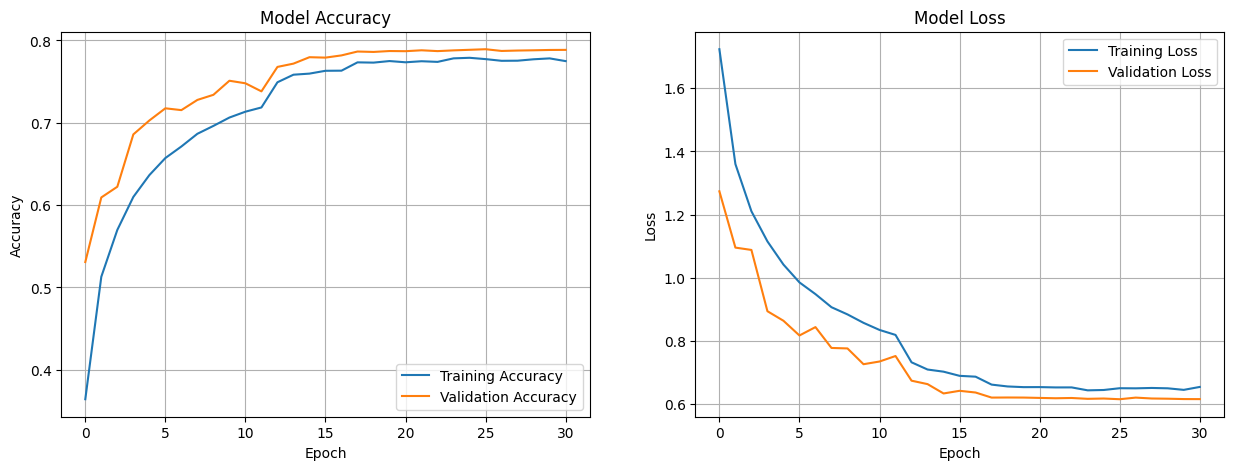

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.show()

plot_history(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test_one_hot, verbose=2)

print(f"\n--- Model Evaluation ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2025-11-10 10:39:22.620318: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 122880000 exceeds 10% of free system memory.


313/313 - 2s - 7ms/step - accuracy: 0.7894 - loss: 0.6148

--- Model Evaluation ---
Test Loss: 0.6148
Test Accuracy: 78.94%


  9/313 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   

2025-11-10 10:39:25.100592: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 122880000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    airplane       0.78      0.85      0.81      1000
  automobile       0.89      0.92      0.90      1000
        bird       0.76      0.63      0.69      1000
         cat       0.67      0.56      0.61      1000
        deer       0.78      0.73      0.75      1000
         dog       0.72      0.68      0.70      1000
        frog       0.74      0.91      0.82      1000
       horse       0.79      0.85      0.82      1000
        ship       0.91      0.87      0.89      1000
       truck       0.84      0.89      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000


--- Confusion Matrix ---


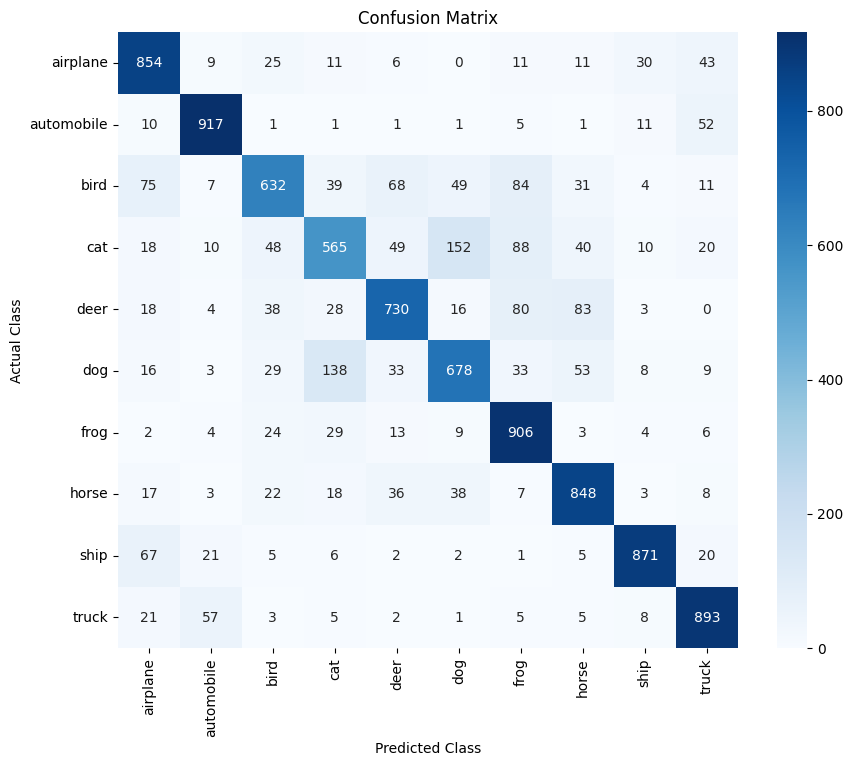

In [ ]:
y_pred_probs = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class labels
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

## Question 4: How can you further improve model performance?

- If our accuracy is low (e.g., < 80%), we can try several things:

    1. Better Architecture: Our model is simple. We could build a deeper network (more Conv2D layers) or use a more modern, pre-built architecture like ResNet or VGG16.

    2. More Data Augmentation: We only used horizontal flips and shifts. We could add random rotations and zooms to create even more varied training data.

    3. More Dropout: We could add Dropout layers after our pooling layers to regularize the convolutional blocks themselves.

    4. Hyperparameter Tuning: We could experiment with different learning rates, batch sizes, or even switch the optimizer (e.g., to RMSprop or SGD with momentum) to find a better combination.

## Question 5: Discuss Optimization Strategies

1. Early Stopping:

    - EarlyStopping monitors the val_loss. If the validation loss stops decreasing for a patience number of epochs (we set patience=5), the training automatically stops.

    - It prevents overfitting and saves time. It automatically stops the model at its peak performance, before it starts to memorize the training data.

2. Learning Rate Scheduling:

    - ReduceLROnPlateau is a type of LR scheduler. It monitors the val_loss. If the loss "plateaus" (stops improving for patience=2 epochs), it reduces the learning rate (we set factor=0.2).

    - This allows the best of both worlds. The model starts with a higher LR for fast learning, then "slows down" to take smaller, more careful steps as it gets closer to the optimal solution.

3. Weight Initialization:

    - Initialization is crucial. If we start all weights at 0, every neuron in a layer will learn the exact same thing (the "symmetry problem"), and the network will fail. If we initialize weights too large, the relu or tanh activation functions will "saturate" (output 0 or 1), leading to zero gradients. If the gradient is 0, no learning can happen.

    - Good initialization (like glorot_uniform or he_normal, which Keras uses by default) sets the weights in a "sweet spot" where the gradient signal is strong. This ensures the backpropagation algorithm works efficiently from the very first epoch, leading to much faster and more stable convergence.